# 2020 Presidential Election Odds

This notebook uses the implied state-by-state election odds from PredictIt.org and performs MonteCarlo simulations of electoral college results. The worksheet should be re-run to get the latest estimate.

## Imports

In [1]:
#!pip install pandas matplotlib

In [1]:
import requests
import time
import urllib.request
import json
from random import randint, random
import re
from matplotlib import pyplot as plt
import pandas as pd

## Store state electoral college votes

In [38]:
# The amount by which democratic state-wise odds are over-estimated by the markets
closet_trumpers_factor = 0.03

# TRUMP SCHEME

# States with this comment are:
#  a) swing states and 
#  b) have republican controlled legislatures

# trump_scheme_success_p is the probability that Trump will:
#  a) dispute the election results of those states, and 
#  b) that the legislatures will vote in his favor

# Thus contributing 0 votes to the Biden campaign.
trump_scheme_success_p = 0.75

# The maximum number of EC votes that could go to 3rd party candidates
max_3rd_party_votes = 0

states = {
    'AL': { 'state':'Alabama', 'abbrev': 'AL', 'votes': 9, },
    'AK': { 'state':'Alaska', 'abbrev': 'AK', 'votes': 3, },
    'AZ': { 'state':'Arizona', 'abbrev': 'AZ', 'votes': 11, 'scheme': True, }, # TRUMP SCHEME
    'AR': { 'state':'Arkansas', 'abbrev': 'AR', 'votes': 6, },
    'CA': { 'state':'California', 'abbrev': 'CA', 'votes': 55, },
    'CO': { 'state':'Colorado', 'abbrev': 'CO', 'votes': 9, },
    'CT': { 'state':'Connecticut', 'abbrev': 'CT', 'votes': 7, },
    'DE': { 'state':'Delaware', 'abbrev': 'DE', 'votes': 3, },
    'FL': { 'state':'Florida', 'abbrev': 'FL', 'votes': 29, },
    'GA': { 'state':'Georgia', 'abbrev': 'GA', 'votes': 16, },
    'HI': { 'state':'Hawaii', 'abbrev': 'HI', 'votes': 4, },
    'ID': { 'state':'Idaho', 'abbrev': 'ID', 'votes': 4, },
    'IL': { 'state':'Illinois', 'abbrev': 'IL', 'votes': 20, },
    'IN': { 'state':'Indiana', 'abbrev': 'IN', 'votes': 11, },
    'IA': { 'state':'Iowa', 'abbrev': 'IA', 'votes': 6, },
    'KS': { 'state':'Kansas', 'abbrev': 'KS', 'votes': 6, },
    'KY': { 'state':'Kentucky', 'abbrev': 'KY', 'votes': 8, },
    'LA': { 'state':'Louisiana', 'abbrev': 'LA', 'votes': 8, },
    'ME': { 'state':'Maine', 'abbrev': 'ME', 'votes': 4, },
    'MD': { 'state':'Maryland', 'abbrev': 'MD', 'votes': 10, },
    'MA': { 'state':'Massachusetts', 'abbrev': 'MA', 'votes': 11, },
    'MI': { 'state':'Michigan', 'abbrev': 'MI', 'votes': 16, 'scheme': True, }, # TRUMP SCHEME
    'MN': { 'state':'Minnesota', 'abbrev': 'MN', 'votes': 10, },
    'MS': { 'state':'Mississippi', 'abbrev': 'MS', 'votes': 6, },
    'MO': { 'state':'Missouri', 'abbrev': 'MO', 'votes': 10, },
    'MT': { 'state':'Montana', 'abbrev': 'MT', 'votes': 3, },
    'NE': { 'state':'Nebraska', 'abbrev': 'NE', 'votes': 5, },
    'NV': { 'state':'Nevada', 'abbrev': 'NV', 'votes': 6, },
    'NH': { 'state':'New Hampshire', 'abbrev': 'NH', 'votes': 4, },
    'NJ': { 'state':'New Jersey', 'abbrev': 'NJ', 'votes': 14, },
    'NM': { 'state':'New Mexico', 'abbrev': 'NM', 'votes': 5, },
    'NY': { 'state':'New York', 'abbrev': 'NY', 'votes': 29, },
    'NC': { 'state':'North Carolina', 'abbrev': 'NC', 'votes': 15, },
    'ND': { 'state':'North Dakota', 'abbrev': 'ND', 'votes': 3, },
    'OH': { 'state':'Ohio', 'abbrev': 'OH', 'votes': 18, },
    'OK': { 'state':'Oklahoma', 'abbrev': 'OK', 'votes': 7, },
    'OR': { 'state':'Oregon', 'abbrev': 'OR', 'votes': 7, },
    'PA': { 'state':'Pennsylvania', 'abbrev': 'PA', 'votes':20, 'scheme': True, }, # TRUMP SCHEME
    'RI': { 'state':'Rhode Island', 'abbrev': 'RI', 'votes': 4, },
    'SC': { 'state':'South Carolina', 'abbrev': 'SC', 'votes': 9, },
    'SD': { 'state':'South Dakota', 'abbrev': 'SD', 'votes': 3, },
    'TN': { 'state':'Tennessee', 'abbrev': 'TN', 'votes': 11, },
    'TX': { 'state':'Texas', 'abbrev': 'TX', 'votes': 38, },
    'UT': { 'state':'Utah', 'abbrev': 'UT', 'votes': 6, },
    'VT': { 'state':'Vermont', 'abbrev': 'VT', 'votes': 3, },
    'VA': { 'state':'Virginia', 'abbrev': 'VA', 'votes': 13, },
    'WA': { 'state':'Washington', 'abbrev': 'WA', 'votes': 12, },
    'DC': { 'state':'DC', 'abbrev': 'DC', 'votes': 3, },
    'WV': { 'state':'West Virginia', 'abbrev': 'WV', 'votes': 5, },
    'WI': { 'state':'Wisconsin', 'abbrev': 'WI', 'votes': 10, 'scheme': True, }, # TRUMP SCHEME
    'WY': { 'state':'Wyoming', 'abbrev': 'WY', 'votes': 3, },
}

## Pull state-by-state odds from PredictIt.org

In [3]:
def get_api_response(url):
    webURL = urllib.request.urlopen(url)
    data = webURL.read()
    encoding = webURL.info().get_content_charset('utf-8')
    return json.loads(data.decode(encoding))

In [4]:
# Below is the url that fetches all state contracts (from PredictIt homepage)
url = 'https://www.predictit.org/api/Public/MapData/EC'

ec = get_api_response(url)

## Extract prices and match with full state names 

In [29]:
state_prices = []
for market in ec:
    # Use the Domocratic party contract prices
    price = next(contract for contract in market['contracts'] if contract['contractName'] == 'Democratic')['lastClosePrice']
    
    # Extract the state abbreviation from contract name
    state_abbrev = re.match('Which party will win (.+?) ', market['marketName']).groups()[0]
    
    # Ignore the fractional state contracts NE and MN
    try:
        state = states[state_abbrev]
    except:
        continue
        
    state_prices.append({ 
        'dem_price': price, 
        'state_abbrev': state_abbrev, 
        'state': state['state'], 
        'votes': state['votes'],
    })

In [30]:
pd.DataFrame(state_prices)

,dem_price,state_abbrev,state,votes
0,0.04,WV,West Virginia,5
1,0.08,MS,Mississippi,6
2,0.95,HI,Hawaii,4
3,0.96,VT,Vermont,3
4,0.94,WA,Washington,12
5,0.04,WY,Wyoming,3
6,0.88,ME,Maine,4
7,0.94,NY,New York,29
8,0.94,CT,Connecticut,7
9,0.05,ND,North Dakota,3


## Define a simulation of one national election outcome

In [31]:
def generate_dem_election():
    dem_votes_tot = 0
    for state in state_prices:
        # Determine if dems won
        won = random() < (state['dem_price'] - closet_trumpers_factor)
        
        if won:
            # Check if swing state with rep controlled legislature
            scheme = states[state['state_abbrev']].get('scheme', False)
            
            if scheme:
                # Determine if scheme succeeded
                scheme_success = random() < trump_scheme_success_p
            
                # Success: dems get no votes
                if scheme_success:
                    dem_votes = 0
                    
                # Failed: dems get state votes
                else:
                    dem_votes = state['votes']
            
            # If not schemable, dems get state votes
            else:
                dem_votes = state['votes']
             
        # If dems lose the election
        else:
            dem_votes = 0
        
        dem_votes_tot += dem_votes

    # Assume 0-2 electors will go to Democratic leaning 3rd party candidates
    dem_votes_tot -= randint(0, max_3rd_party_votes)
    
    return dem_votes_tot     

## Run many simulated elections

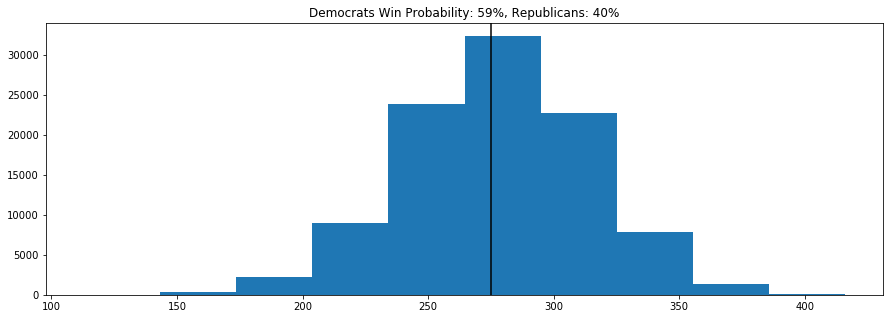

In [39]:
n_elections = 100000

election_set = [generate_dem_election() for n in range(n_elections)]
wins = len([el for el in election_set if el >= 270])
dem_p = wins / len(election_set)
rep_p = 1 - dem_p

plt.figure(figsize=(15,5))
plt.hist(election_set)
plt.axvline(x=275, c='black')
plt.title('Democrats Win Probability: %.2d%%, Republicans: %.2d%%' % (dem_p*100, rep_p*100))
plt.show()